# Neural processes

We'll demonstrate training a neural process and an attentive neural process model using a batch of draws from a Gaussian process. First load some libraries.

In [1]:
import haiku as hk
import jax.numpy as np
import jax.random as random

%matplotlib inline
import matplotlib.pyplot as plt
import palettes

from ramsey.data import sample_from_gaussian_process
from ramsey.train import train_neural_process

palettes.set_theme()

Next we sample some data from a Gaussian process:

In [2]:
key = random.PRNGKey(12)
key, sample_key = random.split(key, 2)

(x_target, y_target), f_target = sample_from_gaussian_process(
    sample_key, batch_size=10, num_observations=200
)

Visualize the batch of draws:

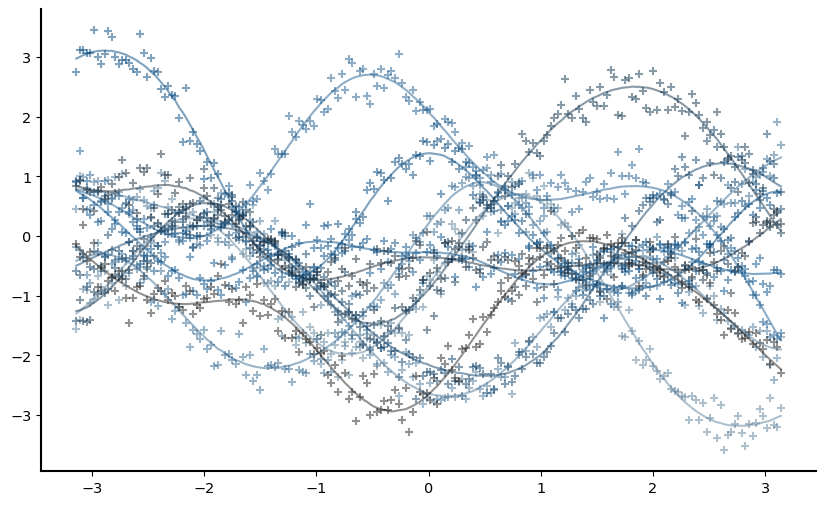

In [3]:
cols = palettes.discrete_sequential_colors(10)

_, ax = plt.subplots(figsize=(10, 6))
for i in range(x_target.shape[0]):
    x = np.squeeze(x_target[i, :, :])
    y = np.squeeze(y_target[i, :, :])
    f = np.squeeze(f_target[i, :, :])
    idxs = np.argsort(x)
    ax.plot(x[idxs], f[idxs], color=cols[i], alpha=0.5)
    ax.scatter(x[idxs], y[idxs], marker="+", color=cols[i], alpha=0.5)
plt.show()

# Neural process

Having sampled a data set, we can define the model. A neural process model takes a `decoder` argument, a `latent_encoder` argument and an optional `deterministic_encoder` argument.

- The `decoder` is a neural network, typically an MLP, that maps the latent representation to the data space, or, more specifically, is used to parameterize an exponential family distribution. The decoder needs to respect the dimensionality of the response to be modelled. For instance, if the response is a univariate Gaussian the last layer needs to have two neurons: one do parameterize the mean and one to parameterize the variance of the Gaussian.

- The `latent_encoder` is a tuple of two neural networks, typically also two MLPs. The first of which maps the data to a latent representation. This representation gets averaged and then passed through the second MLP to parameterize a latent Gaussian.

- The `deterministic_encoder` is typically also an MLP that maps the data two a deterministic univariate representation.

Below we create a simple NP model with a decoder and a latent encoder. All networks are MLPs. The decoder has two neurons in its final layer (for mean and variance of the Gaussian that models the data), the encoder's final layer is 2*128 nodes to parameterize a latent 128 dimensional Gaussian.

In [4]:
from ramsey import NP


def neural_process(**kwargs):
    dim = 128
    np = NP(
        decoder=hk.nets.MLP([dim] * 3 + [2]),
        latent_encoder=(hk.nets.MLP([dim] * 3), hk.nets.MLP([dim, dim * 2])),
    )
    return np(**kwargs)


neural_process = hk.transform(neural_process)

Next we initialize the set of parameters and train the model with a routine provided in `ramsey`:

In [5]:
key, init_key = random.split(key, 2)
params = neural_process.init(
    init_key, x_context=x_target, y_context=y_target, x_target=x_target
)

We use 10 context points and 20 target points per iteration of training:

In [6]:
key, train_key = random.split(key, 2)

n_context, n_target = 10, 20
params, objectives = train_neural_process(
    neural_process,
    params,
    train_key,
    x=x_target,
    y=y_target,
    n_context=n_context,
    n_target=n_target,
    n_iter=10000,
)

That's it! Finally, we define a set of data points for a batch and make some predictions: 

In [7]:
key, sample_key = random.split(key, 2)

sample_idxs = random.choice(
    sample_key, x_target.shape[1], shape=(n_target + n_context,), replace=False
)

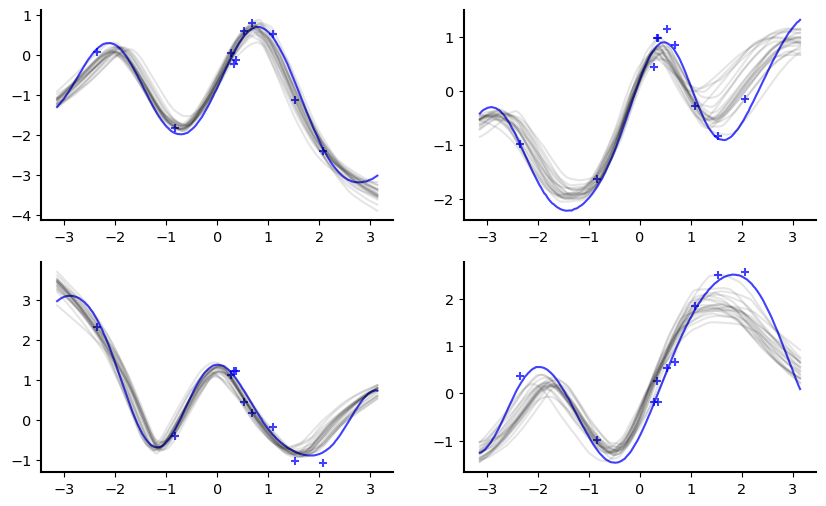

In [8]:
idxs = [0, 2, 5, 7]

_, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for _, (idx, ax) in enumerate(zip(idxs, axes.flatten())):
    x = np.squeeze(x_target[idx, :, :])
    f = np.squeeze(f_target[idx, :, :])
    y = np.squeeze(y_target[idx, :, :])

    srt_idxs = np.argsort(x)
    ax.plot(x[srt_idxs], f[srt_idxs], color="blue", alpha=0.75)
    ax.scatter(
        x[sample_idxs[:n_context]],
        y[sample_idxs[:n_context]],
        color="blue",
        marker="+",
        alpha=0.75,
    )

    for i in range(20):
        key, apply_key = random.split(key, 2)
        y_star = neural_process.apply(
            params=params,
            rng=apply_key,
            x_context=x[np.newaxis, sample_idxs, np.newaxis],
            y_context=y[np.newaxis, sample_idxs, np.newaxis],
            x_target=x_target[[idx], :, :],
        ).mean
        x_star = np.squeeze(x_target[[idx], :, :])
        y_star = np.squeeze(y_star)
        ax.plot(x_star[srt_idxs], y_star[srt_idxs], color="black", alpha=0.1)
plt.show()

# Attentive neural process

An attentive neural process model takes a `decoder` argument, a `latent_encoder` argument and a `deterministic_encoder` argument with an attention module. In comparison to before the
`deterministic_encoder` is also a tuple in this case. In addition to the network that generates the representation, one is also requires to provide a mechanism for cross-attention.

Below we create an ANP model with a decoder a latent encoder and a deterministic encoder with `MultiHeadAttention`. The encoder itself is again an MLP, the `MultiHeadAttention` module takes also an MLP that embeds the keys and query into a higher dimensional space before attending to the query.

In [9]:
from ramsey import ANP
from ramsey.attention import MultiHeadAttention


def attentive_neural_process(**kwargs):
    dim = 128
    np = ANP(
        decoder=hk.nets.MLP([dim] * 3 + [2]),
        latent_encoder=(hk.nets.MLP([dim] * 3), hk.nets.MLP([dim, dim * 2])),
        deterministic_encoder=(
            hk.nets.MLP([dim] * 3),
            MultiHeadAttention(
                num_heads=8, head_size=16, embedding=hk.nets.MLP([dim] * 2)
            ),
        ),
    )
    return np(**kwargs)


attentive_neural_process = hk.transform(attentive_neural_process)

After the setup, the initialization of parameters and training is identical.

In [10]:
key, init_key, train_key = random.split(key, 3)

params = attentive_neural_process.init(
    init_key, x_context=x_target, y_context=y_target, x_target=x_target
)

params, objectives = train_neural_process(
    attentive_neural_process,
    params,
    train_key,
    x=x_target,
    y=y_target,
    n_context=n_context,
    n_target=n_target,
    n_iter=10000,
)

We again visualize some predictions.

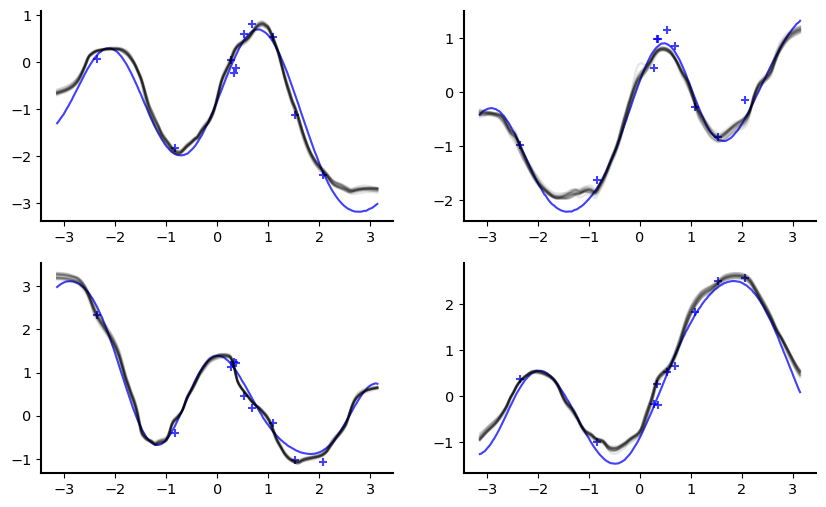

In [11]:
idxs = [0, 2, 5, 7]

_, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for _, (idx, ax) in enumerate(zip(idxs, axes.flatten())):
    x = np.squeeze(x_target[idx, :, :])
    f = np.squeeze(f_target[idx, :, :])
    y = np.squeeze(y_target[idx, :, :])

    srt_idxs = np.argsort(x)
    ax.plot(x[srt_idxs], f[srt_idxs], color="blue", alpha=0.75)
    ax.scatter(
        x[sample_idxs[:n_context]],
        y[sample_idxs[:n_context]],
        color="blue",
        marker="+",
        alpha=0.75,
    )

    for i in range(20):
        key, apply_key = random.split(key, 2)
        y_star = attentive_neural_process.apply(
            params=params,
            rng=apply_key,
            x_context=x[np.newaxis, sample_idxs, np.newaxis],
            y_context=y[np.newaxis, sample_idxs, np.newaxis],
            x_target=x_target[[idx], :, :],
        ).mean
        x_star = np.squeeze(x_target[[idx], :, :])
        y_star = np.squeeze(y_star)
        ax.plot(x_star[srt_idxs], y_star[srt_idxs], color="black", alpha=0.1)
plt.show()

We can see that the predictions have significantly less variance as before.